In [2]:
import sys
sys.path.append("../..")

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss

from transfernode import node
from transfernode import line
from stochastic import stochastic
from genetics import ga

In [ ]:
avtovokzal = node.Node()
# start times counting from 5AM: [75, 90, 30, 95, 0]
# start times counting from 6:30AM: [20, 0, 0, 5, 14]
line1 = line.Line(20, 15 + 20, stochastic.Stochastic(1, 3, 0.5), 0.35, "#1")
line2 = line.Line(0, 30, stochastic.Stochastic(1, 4, 1), 0.20, "#2")
line3 = line.Line(0, 20, stochastic.Stochastic(1, 5, 1), 0.25, "#3")
line4 = line.Line(5, 28, stochastic.Stochastic(1, 4, 0.5), 0.10, "#4")
line5 = line.Line(14, 26, stochastic.Stochastic(1, 4, 0.5), 0.10, "#5")

avtovokzal.origin_pass_number = 250  # [pas./h] !!!!! -> 12 pas./h (itvl = 5 min as for net simulatinos)
avtovokzal.lines = [line1, line2, line3, line4, line5]

In [4]:
nd, dur, N = avtovokzal, 180, 300

def fitness_function(shifts):
    for idx in range(len(nd.lines)):
        nd.lines[idx].shift = shifts[idx]
    res = []
    for _ in range(N):
        x = nd.simulate(duration=dur)
        res.append(x[0] / x[1])
    return np.array(res)

res = fitness_function([20, 0, 0, 5, 14])

(13.276066785970851, 0.2846533760049955)


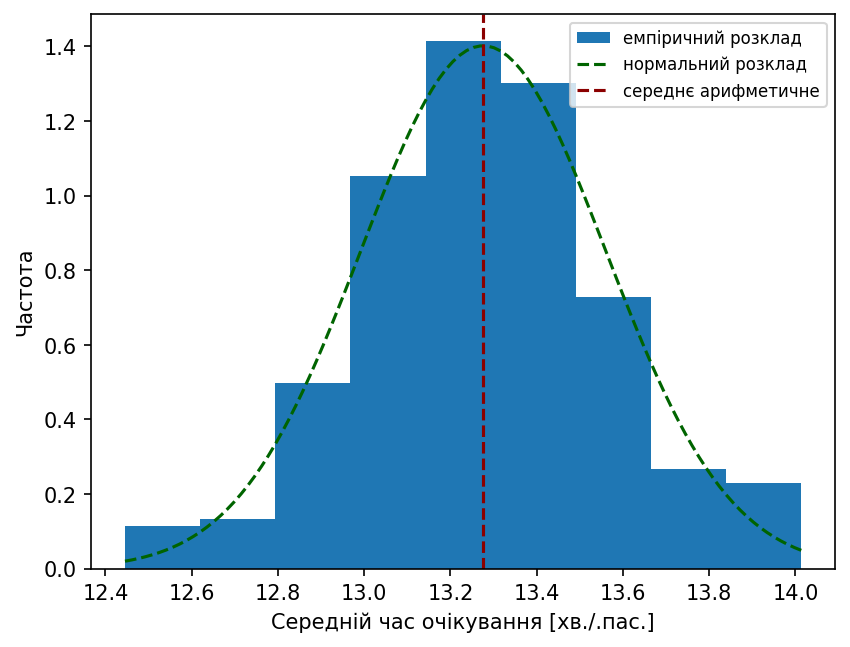

In [6]:
def plot_hist(res):
    xs = np.linspace(min(res), max(res), 100)
    params = ss.norm.fit(res)
    print(params)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(res, bins=9, density=True,
             label='емпіричний розклад')
    plt.plot(xs, ss.norm.pdf(xs, *params), linestyle='--', color='darkgreen',
             label='нормальний розклад')
    plt.axvline(res.mean(), linestyle='--', color='darkred',
                label='середнє арифметичне')
    plt.xlabel('Середній час очікування [хв./.пас.]')
    plt.ylabel('Частота')
    plt.legend(fontsize=8, loc='upper right')
    plt.show()

plot_hist(res)

In [12]:
def needed(xs, alpha=0.05):
    mean = xs.mean()
    var = xs.var()
    u_alpha = ss.norm.ppf(1 - alpha)
    return var * u_alpha**2 / (alpha * mean)**2

needed(res)

0.5557635984429314

## Run GA

In [15]:
N = 10

winners = []
for iter in range(30):
    print(iter + 1)
    g = ga.GA()
    g.chromosome_size = len(avtovokzal.lines), 7
    g.population_size = 100
    g.generations = 20
    g.crossover_probability = 0.5
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = lambda s: fitness_function(s).mean()
    winner = g.run()
    winners.append(winner[1])
    print()

1
winner #1 ([28, 2, 31, 40, 38], (14.107146257231204, <genetics.chromosome.Chromosome object at 0x14f200040>))
winner #2 ([28, 2, 31, 40, 38], (13.985438775746767, <genetics.chromosome.Chromosome object at 0x14f200040>))
winner #3 ([28, 10, 10, 17, 2], (13.035414900253013, <genetics.chromosome.Chromosome object at 0x14f005cf0>))
winner #4 ([28, 10, 10, 17, 2], (13.058513200426692, <genetics.chromosome.Chromosome object at 0x14efb6aa0>))
winner #5 ([28, 18, 7, 11, 16], (12.896884438717715, <genetics.chromosome.Chromosome object at 0x14f1c9240>))
winner #6 ([24, 10, 10, 17, 18], (12.826562717817444, <genetics.chromosome.Chromosome object at 0x14f427640>))
winner #7 ([28, 10, 10, 17, 18], (12.730687672107958, <genetics.chromosome.Chromosome object at 0x14efb6380>))
winner #8 ([24, 10, 10, 17, 18], (12.828966013336366, <genetics.chromosome.Chromosome object at 0x14f427640>))
winner #9 ([28, 10, 10, 17, 16], (12.76344936118529, <genetics.chromosome.Chromosome object at 0x14f426410>))
winne

In [16]:
np.array(winners).tofile('node30x20.txt', sep=',', format='%s')

## Analyze results

In [3]:
xs = np.fromfile('node_results/node30x20.txt', sep=',').reshape((30, 20))

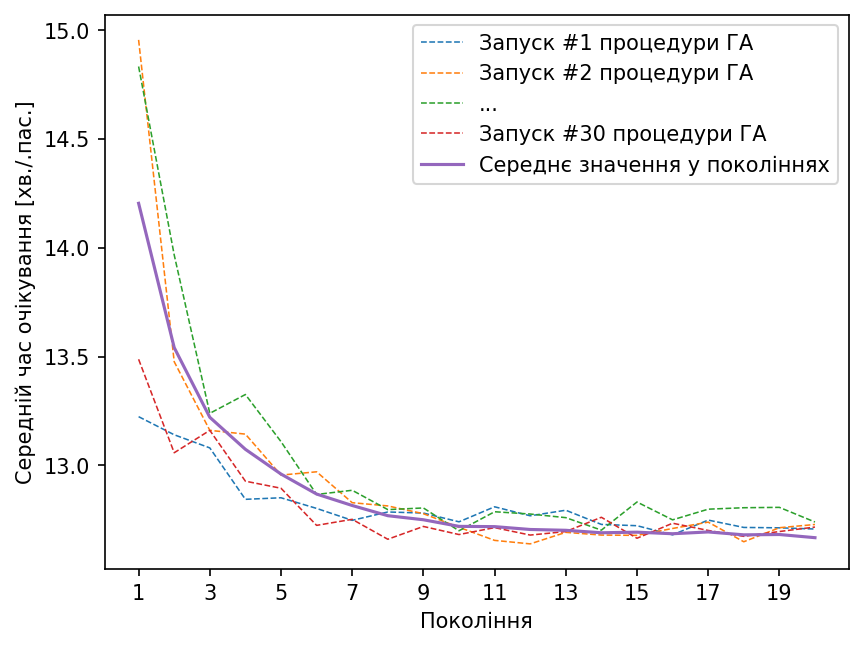

In [4]:
plt.figure(dpi=150)
plt.plot(range(1, 21), xs[9], lw=0.75, label=f'Запуск #1 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[10], lw=0.75, label=f'Запуск #2 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[11], lw=0.75, label=f'...', linestyle='--')
plt.plot(range(1, 21), xs[28], lw=0.75, label=f'Запуск #30 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Покоління')
plt.xticks(range(1,21, 2))
plt.legend()
plt.show()